# COVID-19 Exploratory Data Analysis

In [84]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
init_notebook_mode(connected=True) 

In [4]:
from datetime import date
from datetime import timedelta

today = date.today()
yesterday = today - timedelta(days=2)
yesterday = yesterday.strftime('%m-%d-%Y')

In [5]:
# downloading the data from 2 days before because the data from the current one might not be available yet
import requests
try:
    for filename in ['csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
                    'csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
                    'csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
                    f'csse_covid_19_daily_reports/{yesterday}.csv',
                    f'csse_covid_19_daily_reports_us/{yesterday}.csv']:
        print(f'Downloading {filename}')
        url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/{filename}'
        myfile = requests.get(url)
        full_path = os.path.join('data/',filename)
        #open(filename.split('/')[1],'wb').write(myfile.content)
        open(full_path,'wb').write(myfile.content)
except:
    print('Could not update data, older data will be used instead')


Could not update data, older data will be used instead


The SARS-COV-2 pandemic has been the most important topic worldwide since its beginning in january. It is the biggest crisis of that sort since the spanish flu pandemic in 1918. After the initial outbreak in China, the virus has spread across the world and is now affecting 213 countries and territories on all continents. Correct analysis of the available data is crucial in the process of planning the measures that will allow to slow down the pandemic, while minimizing its effect on the economy and day to day lives of people. 

# Daily report for the whole world

In [6]:
world_total = pd.read_csv(f'data/csse_covid_19_daily_reports/{yesterday}.csv')

## Field description

   FIPS: US only. Federal Information Processing Standards code that uniquely identifies counties within the USA.
    Admin2: County name. US only.
    
   Province_State: Province, state or dependency name.
    
   Country_Region: Country, region or sovereignty name. The names of locations included on the Website correspond with the official designations used by the U.S. Department of State.
    
   Last Update: MM/DD/YYYY HH:mm:ss (24 hour format, in UTC).
    
   Lat and Long_: Dot locations on the dashboard. All points (except for Australia) shown on the map are based on geographic centroids, and are not representative of a specific address, building or any location at a spatial scale finer than a province/state. Australian dots are located at the centroid of the largest city in each state.
    
   Confirmed: Counts include confirmed and probable (where reported).
       
   Deaths: Counts include confirmed and probable (where reported).
    Recovered: Recovered cases are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number. US state-level recovered cases are from COVID Tracking Project.
    
   Active: Active cases = total cases - total recovered - total deaths.
    
   Incidence_Rate: Incidence Rate = cases per 100,000 persons.
    
   Case-Fatality Ratio (%): Case-Fatality Ratio (%) = Number recorded deaths / Number cases.


    The format of the data provided by the Johns Hopkins University in the daily reports can be seen below:

In [7]:
world_total.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-08-16 04:27:42,33.93911,67.709953,37551,1370,27166,9015.0,Afghanistan,96.461855,3.648372
1,NaN,NaN,NaN,Albania,2020-08-16 04:27:42,41.15330,20.168300,7260,225,3746,3289.0,Albania,252.276044,3.099174
2,NaN,NaN,NaN,Algeria,2020-08-16 04:27:42,28.03390,1.659600,38133,1360,26644,10129.0,Algeria,86.960303,3.566465
3,NaN,NaN,NaN,Andorra,2020-08-16 04:27:42,42.50630,1.521800,989,53,863,73.0,Andorra,1280.010354,5.358948
4,NaN,NaN,NaN,Angola,2020-08-16 04:27:42,-11.20270,17.873900,1879,86,628,1165.0,Angola,5.717108,4.576903


Daily report contains data for both US and the rest of the world, explaining the large number of missing values in FIPS, Admin2 and Province_State columns, which are US specific.

In [8]:
world_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3250 non-null   float64
 1   Admin2               3255 non-null   object 
 2   Province_State       3777 non-null   object 
 3   Country_Region       3945 non-null   object 
 4   Last_Update          3945 non-null   object 
 5   Lat                  3865 non-null   float64
 6   Long_                3865 non-null   float64
 7   Confirmed            3945 non-null   int64  
 8   Deaths               3945 non-null   int64  
 9   Recovered            3945 non-null   int64  
 10  Active               3942 non-null   float64
 11  Combined_Key         3945 non-null   object 
 12  Incidence_Rate       3865 non-null   float64
 13  Case-Fatality_Ratio  3893 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 431.6+ KB


# Sum of all cases for each country

In [9]:
# data for choropleth world map
world_sum = world_total[['Country_Region','Confirmed','Deaths','Recovered','Active']]
world_sum = world_sum.groupby('Country_Region').sum()
world_sum['Case-Fatality_Ratio'] = round((world_sum['Deaths']/world_sum['Confirmed'])*100,2)

    The format of the data after summing up all the cases for each country can be seen below:

In [10]:
world_sum.head()

,Confirmed,Deaths,Recovered,Active,Case-Fatality_Ratio
Country_Region,,,,,
Afghanistan,37551,1370,27166,9015.0,3.65
Albania,7260,225,3746,3289.0,3.10
Algeria,38133,1360,26644,10129.0,3.57
Andorra,989,53,863,73.0,5.36
Angola,1879,86,628,1165.0,4.58


# Total sum of confirmed cases, deaths, recoveries and active cases worldwide

In [11]:
total_sum = world_total[['Confirmed','Deaths','Recovered','Active']].sum()
for i,row in enumerate(total_sum):
    print(total_sum.index[i] + f': {int(row):,}')

Confirmed: 21,459,699
Deaths: 771,063
Recovered: 13,445,842
Active: 7,242,527


In [12]:
# top 10 for confirmed cases
top10 = world_sum.sort_values('Confirmed',ascending=False).head(10)
countries = top10.index

# Total sum of confirmed cases, deaths, recoveries and active cases for 10 countries with the most confirmed cases

In [13]:
top10

,Confirmed,Deaths,Recovered,Active,Case-Fatality_Ratio
Country_Region,,,,,
US,5361165,169481,1818527,3373159.0,3.16
Brazil,3317096,107232,2622878,586986.0,3.23
India,2589952,49980,1862258,677444.0,1.93
Russia,915808,15585,727895,172328.0,1.70
South Africa,583653,11677,466941,105035.0,2.00
Mexico,517714,56543,418164,43007.0,10.92
Peru,516296,25856,359781,130659.0,5.01
Colombia,456689,14810,274420,167459.0,3.24
Chile,383902,10395,356951,16556.0,2.71


In [14]:
# utility function for extracting the data for the hotspot countries
def process_time_series(time_series):
    time_series.drop(['Province/State','Lat','Long'], axis=1, inplace=True)
    top10 = time_series[time_series['Country/Region'].isin(countries)].groupby('Country/Region').sum()
    top10.sort_index(inplace=True)
    return top10

# Time series data for all countries

In [15]:
# Reading the time series data and extracting data for top 10 hotspot countries
ts_confirmed = pd.read_csv('data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
ts_deaths = pd.read_csv('data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
ts_recovered = pd.read_csv('data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

top10_confirmed = process_time_series(ts_confirmed)
top10_deaths = process_time_series(ts_deaths)
top10_recovered = process_time_series(ts_recovered)

The format of the data provided by the Johns Hopkins University in the time series reports can be seen below:

In [16]:
ts_confirmed.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551
1,Albania,0,0,0,0,0,0,0,0,0,...,6016,6151,6275,6411,6536,6676,6817,6971,7117,7260
2,Algeria,0,0,0,0,0,0,0,0,0,...,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133
3,Andorra,0,0,0,0,0,0,0,0,0,...,944,955,955,955,963,963,977,981,989,989
4,Angola,0,0,0,0,0,0,0,0,0,...,1483,1538,1572,1672,1679,1735,1762,1815,1852,1879


# Worldwide Confirmed cases, deaths and recoveries over time

In [17]:
# Time series sum of cases from all the countries
confirmed = ts_confirmed.drop('Country/Region',axis=1).sum()
confirmed.index = pd.to_datetime(confirmed.index)

deaths = ts_deaths.drop('Country/Region',axis=1).sum()
deaths.index = pd.to_datetime(deaths.index)
  
recovered = ts_recovered.drop('Country/Region',axis=1).sum()
recovered.index = pd.to_datetime(recovered.index)
    
concatenated = pd.concat([confirmed,recovered,deaths],axis=1)
concatenated.columns = ['Confirmed','Recovered','Deaths']

In [18]:
# Formatting of the ticks in the line plots
@ticker.FuncFormatter
def major_formatter(x,pos):
    return '%1.1fM' % (x*1e-6)

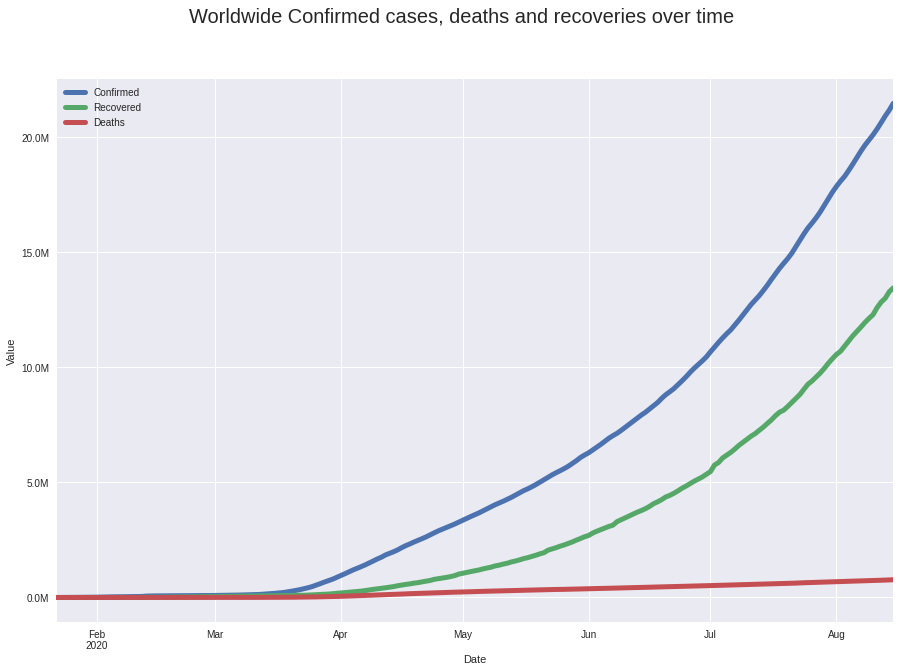

In [19]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,10))
plt.suptitle('Worldwide Confirmed cases, deaths and recoveries over time', fontsize=20)

ax = fig.add_subplot()
concatenated.plot(linewidth=5, ax=ax)
plt.xlabel('Date')
plt.ylabel('Value')
ax.yaxis.set_major_formatter(major_formatter)

* Confirmed cases appear to be growing exponentially, so do the recoved cases and the deaths, although with a much lower growth factor

In [20]:
# Formatting of the ticks in the line plots for the log scale
@ticker.FuncFormatter
def major_formatter(x,pos):
    if x >= 1e6:
        return '%1.0fM' % (x*1e-6)
    elif x >= 1e4:
        return '%1.0fk' % (x*1e-3)
    else:
        return '%1.0f' % (x)

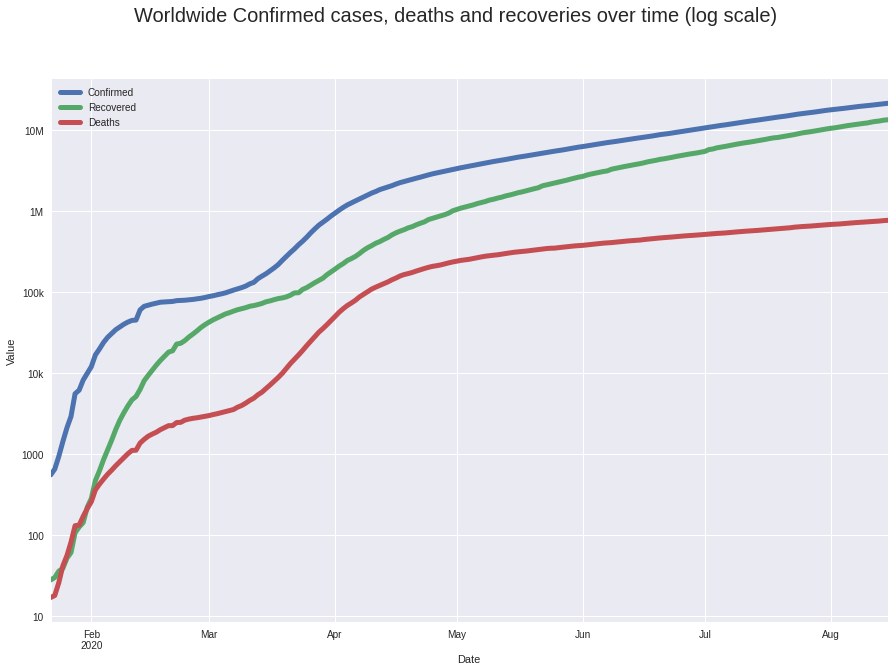

In [21]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,10))
plt.suptitle('Worldwide Confirmed cases, deaths and recoveries over time (log scale)', fontsize=20)

ax = fig.add_subplot()
concatenated.plot(linewidth=5, ax=ax)
plt.xlabel('Date')
plt.ylabel('Value')
plt.yscale('log')
ax.yaxis.set_major_formatter(major_formatter)

* In the logarithmic scale it can be seen more clearly that all of the plots are growing exponentially
* After the worst period of time in march, the growth seems to have slowed down, indicating that the measures taken by the countries to 'flatten the curve' have been at least partially succesfull
* Since the lockdowns were imposed the growth factor of the pandemic has decreased and appears stable since may
* The effects of the end of lockdowns as well as other incursions like anti-mask protests are yet to be seen in the worldwide totals

# Case-fatality ratio over time

In [22]:
CaseFatality_Ratio = round((concatenated['Deaths']/concatenated['Confirmed'])*100,2)

In [23]:
# Formatting of the ticks in the line plots
@ticker.FuncFormatter
def major_formatter(x,pos):
    return '%1.2f' % (x*1e-2)

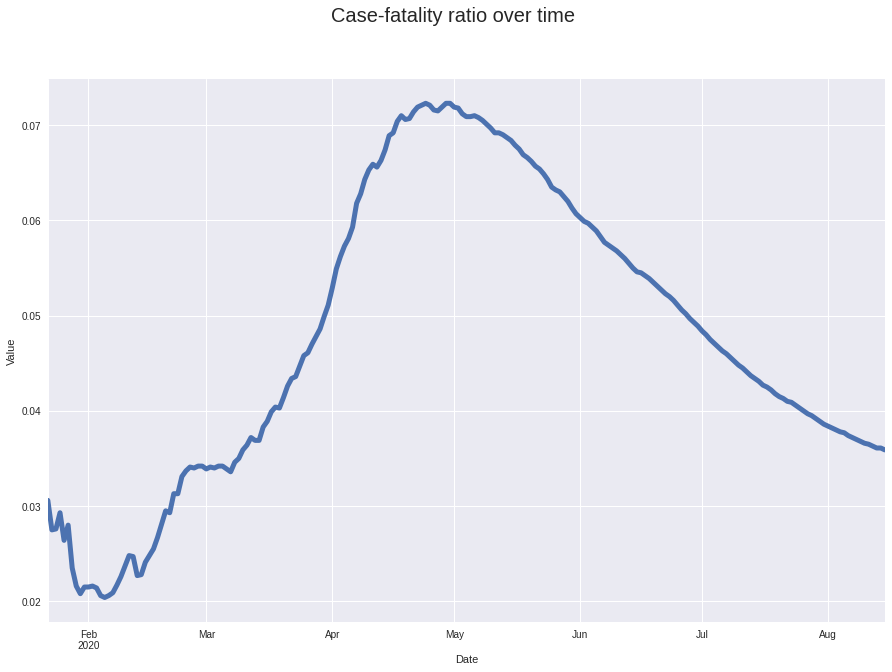

In [24]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,10))
plt.suptitle('Case-fatality ratio over time', fontsize=20)

ax = fig.add_subplot()
CaseFatality_Ratio.plot(linewidth=5, ax=ax)
plt.xlabel('Date')
plt.ylabel('Value')
ax.yaxis.set_major_formatter(major_formatter)

It can be clearly seen that after the initial rise of mortality since the beginning of the pandemic until may, the mortality has seen a large drop to the levels similar like in march. That is consisten with the reports that lately more young people get infected, who generally tend to survive the infection more easily.

# Worldwide growth factor over time

In [25]:
# Get the worldwide sum of the confirmed cases
confirmed = ts_confirmed.drop('Country/Region',axis=1).sum()
confirmed.index = pd.to_datetime(confirmed.index)

In [26]:
# Create the data series for the growth factor calculation
next_day = confirmed.iloc[1:].reset_index(drop=True)
previous_day = confirmed.iloc[:-1].reset_index(drop=True)
new_cases = next_day - previous_day

In [27]:
# Growth factor calculation by dividing the cases from the new day by the cases in the previous day
growth_factor = pd.DataFrame(new_cases.iloc[1:].reset_index(drop=True).div(new_cases[:-1].reset_index(drop=True)))

In [28]:
growth_factor.set_index(confirmed.index[1:-1],inplace=True)
growth_factor.columns = ['Growth factor']

Text(0, 0.5, 'Value')

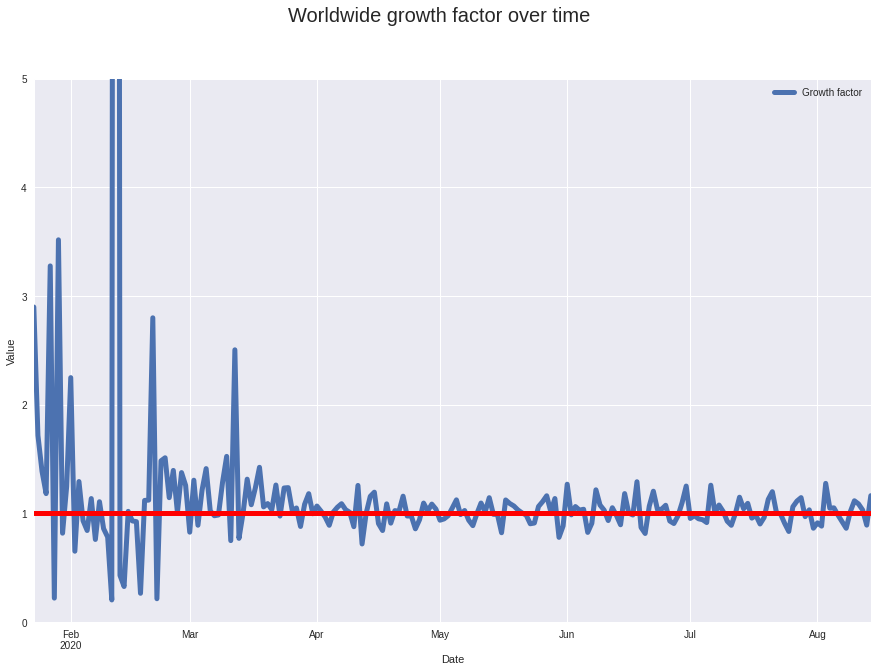

In [29]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,10))
plt.suptitle('Worldwide growth factor over time', fontsize=20)

ax1 = fig.add_subplot()
growth_factor.plot(linewidth=5, ax=ax1)

plt.axhline(y=1, color='r', linewidth=5)

plt.xlabel('Date')
plt.ylim(0,5)
plt.ylabel('Value')

Growth factor of 1 (marked with a red line in the plot) means that the new cases are not decreasing or increasing, below 1 means that they are decreasing and above 1 that they are increasing. After very high values of that factor at the very beginning of the pandemic, the value has more or less stabilized around the value 1, so overall, worldwide the number of new cases doesn't change significantly. To end the pandemic we will need to lower the growth factor below 1.

# Confirmed cases, deaths and recoveries over time for 10 hotspot countries

In [30]:
# utility function for creating a dataframe for graphing for a specified country
def extract_country_data(name,ts_confirmed,ts_deaths,ts_recovered):
    
    confirmed = pd.DataFrame(ts_confirmed.loc[name])
    confirmed.index = pd.to_datetime(confirmed.index)
    confirmed.columns = ['Confirmed']
    
    deaths = pd.DataFrame(ts_deaths.loc[name])
    deaths.index = pd.to_datetime(deaths.index)
    deaths.columns = ['Deaths']
    
    recovered = pd.DataFrame(ts_recovered.loc[name])
    recovered.index = pd.to_datetime(recovered.index)
    recovered.columns = ['Recovered']
    
    concatenated = pd.concat([confirmed,recovered,deaths],axis=1)
    return concatenated

In [31]:
# appending the dataframes for each hotspot country into a list
top10_total_data = []

for country in countries:
    top10_total_data.append((country,extract_country_data(country,top10_confirmed,top10_deaths,top10_recovered)))

In [32]:
# Formatting of the ticks in the line plots for the log scale
@ticker.FuncFormatter
def major_formatter(x,pos):
    if x >= 1e6:
        return '%1.1fM' % (x*1e-6)
    elif x >= 1e4:
        return '%1.0fk' % (x*1e-3)
    else:
        return '%1.0f' % (x)

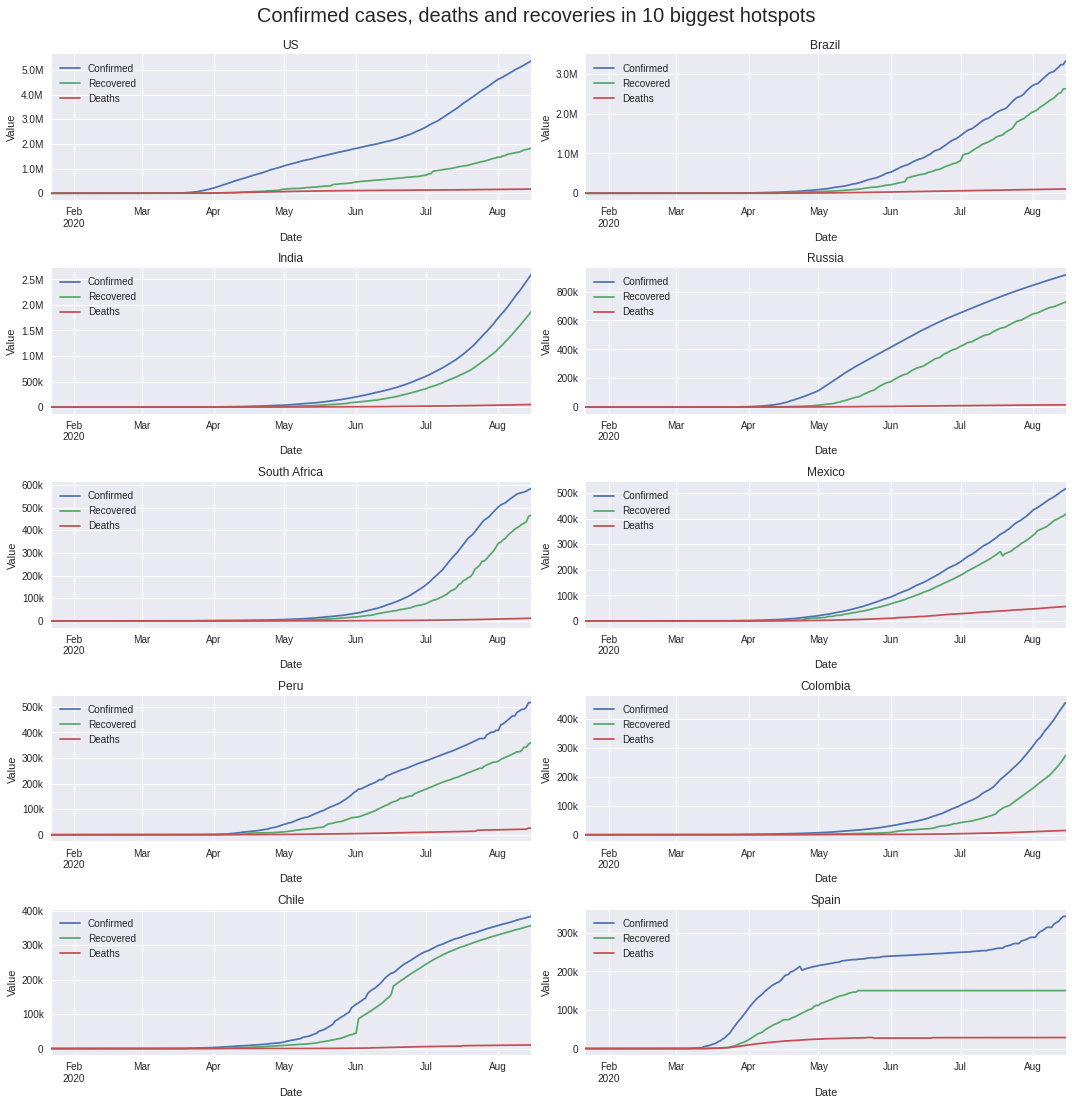

In [33]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
plt.suptitle('Confirmed cases, deaths and recoveries in 10 biggest hotspots', fontsize=20,y=1.02)

for i in range(0,10):
    ax = fig.add_subplot(5,2,i+1)
    plt.title(top10_total_data[i][0])
    plt.xlabel('Date')
    plt.ylabel('Value')
    top10_total_data[i][1].plot(kind='line',ax=ax)
    ax.yaxis.set_major_formatter(major_formatter)
    
plt.tight_layout()

Looking at the 10 countries with the most confirmed cases we can see that the situation there currently is mostly getting worse:
* countries like India, Brazil and Colombia are still experiencing exponential growth of the number of cases
* Spain after a period of relative stability where the growth has been slowed down by the lockdown of the country is experiencing a second wave, whether that can be mitigated by the mandatory use of masks and social distancing or the second lockdown will be necesarry, yet remains to be seen in the coming weeks
* USA after partially suppressing the initial outbreak has decided to end the lockdown prematurely and is now experiencing a second wave that so far appears to be significantly worse than the first one
* Russia, South Africa and Chile show signs of stopping the exponential growth of cases

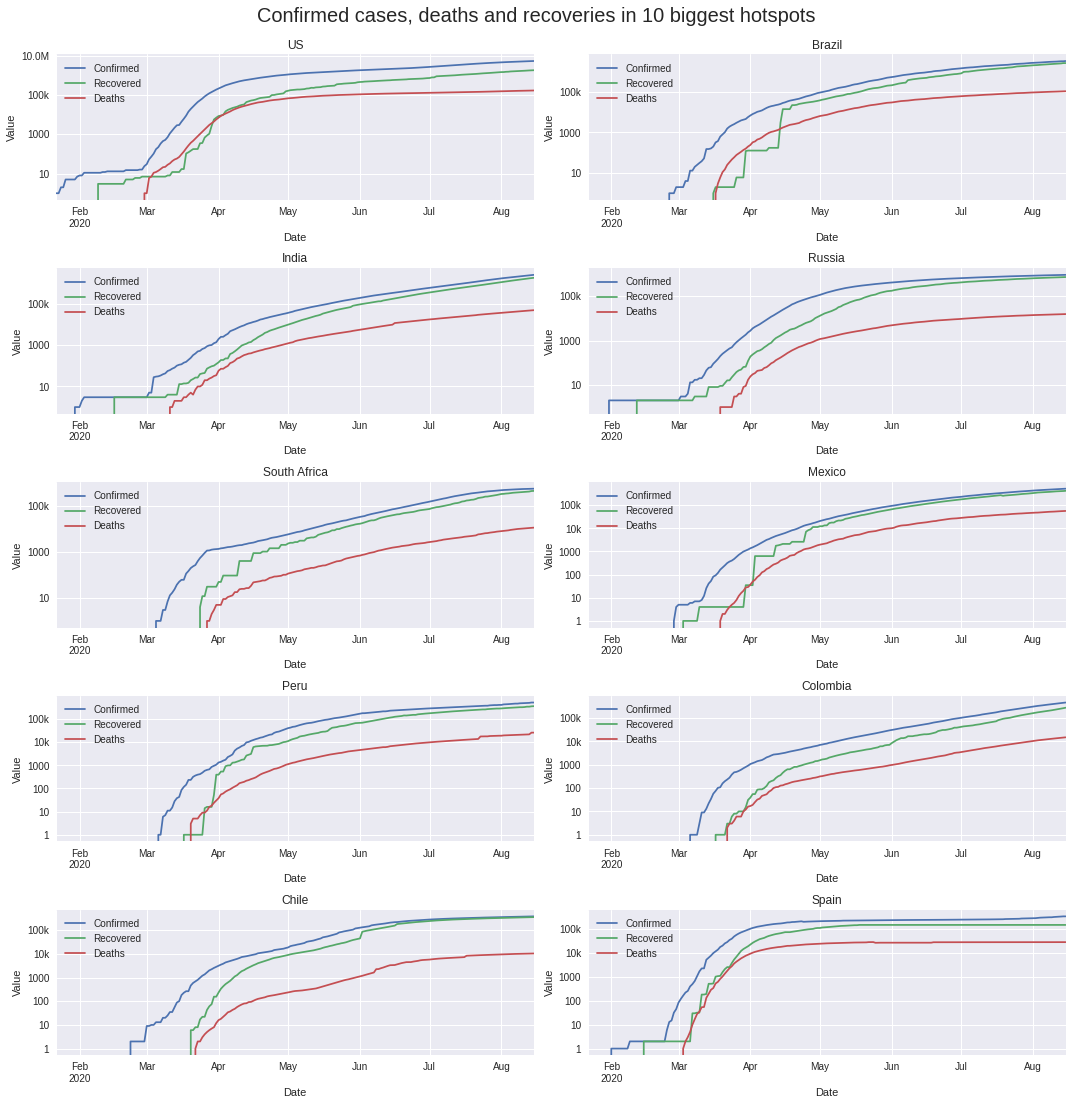

In [34]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
plt.suptitle('Confirmed cases, deaths and recoveries in 10 biggest hotspots', fontsize=20,y=1.02)

for i in range(0,10):
    ax = fig.add_subplot(5,2,i+1)
    plt.title(top10_total_data[i][0])
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.yscale('log')
    top10_total_data[i][1].plot(kind='line',ax=ax)
    ax.yaxis.set_major_formatter(major_formatter)
    
plt.tight_layout()

Logarithmic scale plots confirm earlier observations:
* Growth factor appears to be increasing in Spain
* Russia, South Africa and Chile appear to be slowly stabilizing
* Other countries shown are still registering an exponential growth of the number of cases

# Area plots of confirmed cases, deaths and recoveries for 10 hotspot countries

In [35]:
# Formatting of the ticks in the line plots for the log scale
@ticker.FuncFormatter
def major_formatter(x,pos):
    if x >= 1e6:
        return '%1.1fM' % (x*1e-6)
    elif x >= 1e4:
        return '%1.0fk' % (x*1e-3)
    else:
        return '%1.0f' % (x)

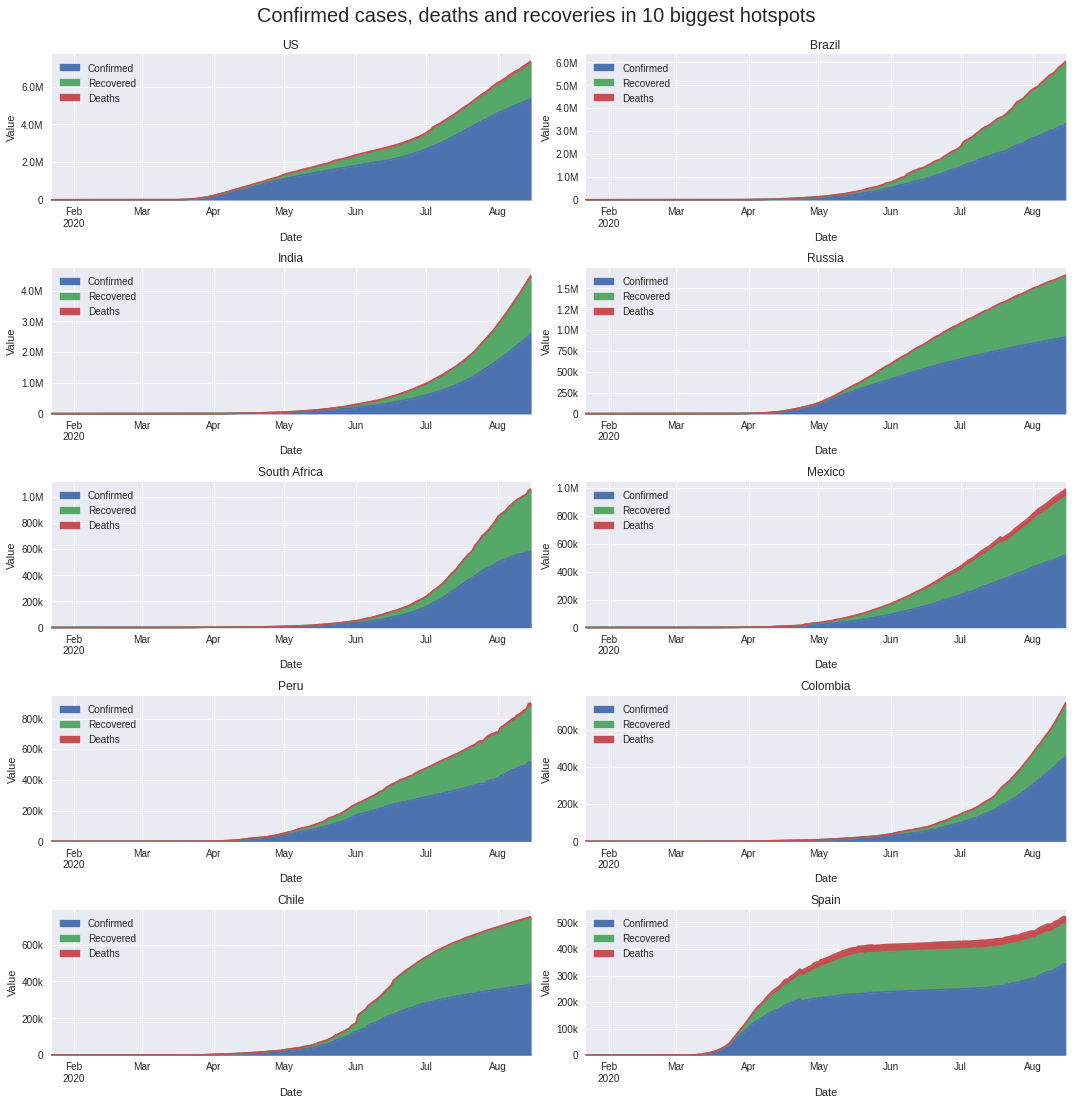

In [36]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
plt.suptitle('Confirmed cases, deaths and recoveries in 10 biggest hotspots', fontsize=20,y=1.02)

for i in range(0,10):
    ax = fig.add_subplot(5,2,i+1)
    plt.title(top10_total_data[i][0])
    plt.xlabel('Date')
    plt.ylabel('Value')
    top10_total_data[i][1].plot(kind='area',ax=ax)
    ax.yaxis.set_major_formatter(major_formatter)
    
plt.tight_layout()

# Barplots of confirmed cases, deaths, recoveries and active cases for 10 hotspot countries

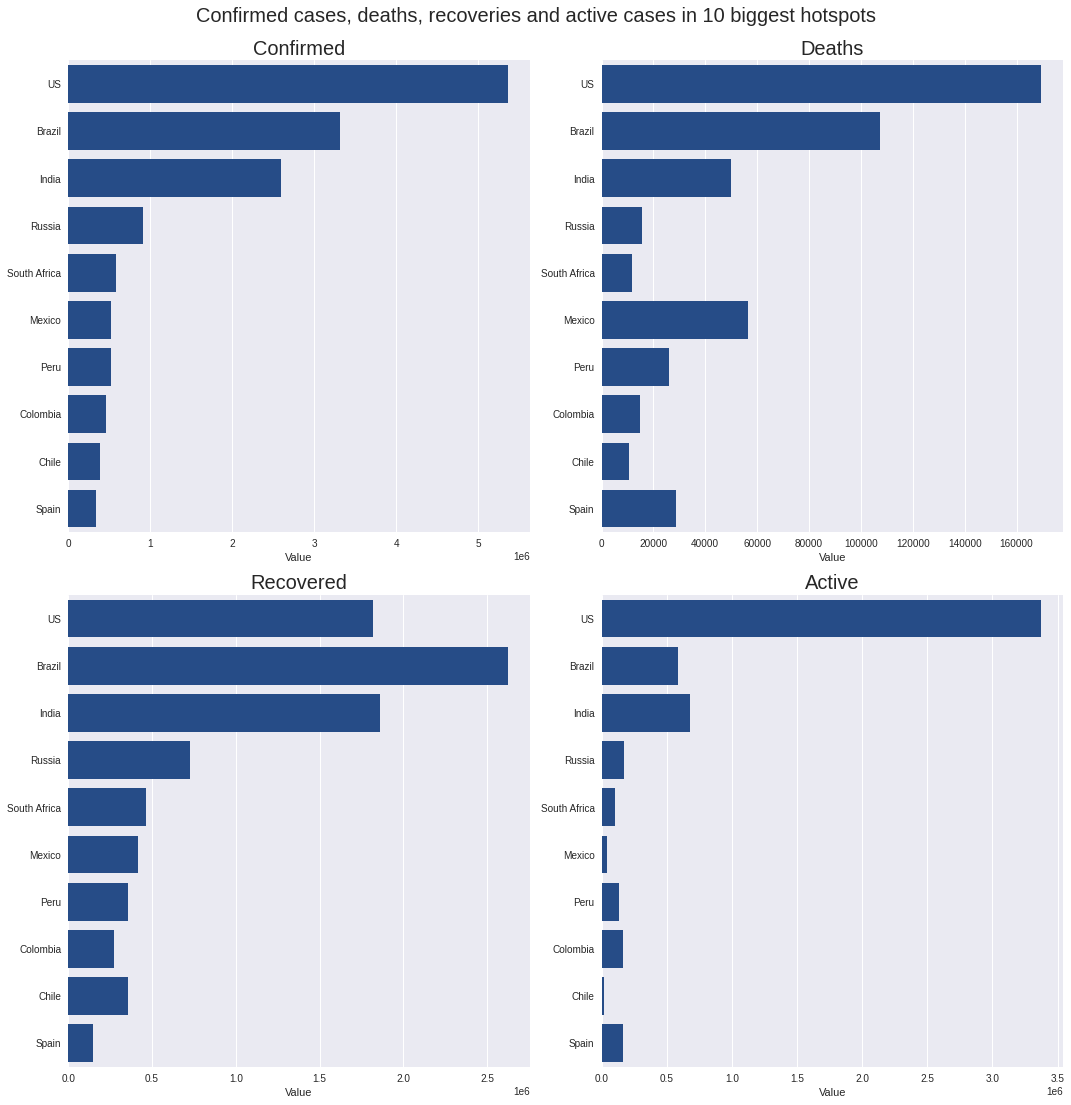

In [37]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,15))
plt.suptitle('Confirmed cases, deaths, recoveries and active cases in 10 biggest hotspots', fontsize=20,y=1.02)
columns = top10.columns

for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    sns.barplot(x=columns[i], y=top10.index,data=top10, color='#164897')
    plt.title(columns[i],fontsize=20)
    plt.ylabel('')
    plt.xlabel('Value') 
    
plt.tight_layout()

Currently USA appears to be the epicenter of the pandemic, with nearly double the confirmed cases and deaths than the second country, Brazil. US also has a lot more active cases than any other country. Brazil and India however are also experiencing a pretty rapid spread of the outbreak, so that situation may soon change, depending on the actions of their governments. 

# Choropleth map of the case fatality ratio worldwide

In [38]:
# dictionary for the plotly map
data = dict(type = 'choropleth',
            locations = world_sum.index,
            locationmode = 'country names',
            colorscale= 'reds',
            text= world_sum['Confirmed'],
            z=world_sum['Case-Fatality_Ratio'],
            colorbar = {'title':'Confirmed cases per 100k around the world'})

In [39]:
layout = dict(geo = {'scope':'world'})

In [40]:
choromap = go.Figure(data = [data],layout = layout)

In [41]:
# map of the case fatality ratio (%)
iplot(choromap)

Yemen seems to have the worst mortality so far at 28.42%, but also they have a relatively small number of confirmed cases at 1858, so most likely the testing capacity is insufficient and mostly the grave cases are reported, inflating the mortality rate. Many countries of western Europe have currently a high case fatality ratio, as well as Mexico and Canada, whereas in South America, Asia and Africa that marker seems to be much lower. Overall, it is hard to estimate the real deadliness of SARS-COV-2 because the estimates are dependent on ability to confirm cases, and with a large number of asymptomatic cases, that proves to be a difficult task

# Choropleth map of confirmed cases in Europe

In [42]:
# list of all european countries
europe = ['Portugal','Spain','Iceland','Ireland','United Kingdom','France','Belgium','Netherlands','Italy',
          'Germany','Switzerland','Austria','Denmark','Norway','Sweden','Finland','Russia','Estonia','Latvia',
         'Lithuania','Poland','Belarus','Czechia','Ukraine','Moldova','Romania','SLovakia','Hungary','Slovenia',
         'Croatia','Bosnia and Herzegovina','Montenegro','Albania','Serbia','Bulgaria','North Macedonia','Greece']

In [43]:
# sum of all the cases for each european country
europe_sum = world_total[['Country_Region','Confirmed','Deaths','Recovered','Active']]

In [44]:
europe_sum = europe_sum[europe_sum['Country_Region'].isin(europe)].groupby('Country_Region').sum()

In [45]:
europe_sum.head()

,Confirmed,Deaths,Recovered,Active
Country_Region,,,,
Albania,7260,225,3746,3289.0
Austria,23179,728,20627,1824.0
Belarus,69308,603,66452,2253.0
Belgium,77869,9935,17981,49953.0
Bosnia and Herzegovina,15801,471,9619,5711.0


In [46]:
# dictionary for the plotly map
data = dict(type = 'choropleth',
            locations = europe_sum.index,
            locationmode = 'country names',
            colorscale= 'reds',
            text= europe_sum['Confirmed'],
            z=europe_sum['Confirmed'],
            colorbar = {'title':'Confirmed cases per 100k in Europe'})

In [47]:
layout = dict(geo = {'scope':'europe'})

In [48]:
choromap = go.Figure(data = [data],layout = layout)

In [49]:
# map of the confirmed cases in Europe
iplot(choromap)

Currently, the country with most confirmed cases in Europe is Russia and that is unlikely to change since it has nearly 3 times the number of cases of the second country, Spain. Overall, pandemic has mostly slowed down in Europe, although currently there can be observed a second wave of infections, most visibly in Spain, where the number of daily cases has risen very significantly a few weeks after the country has ended its lockdown. Eastern Europe seems to be significantly less affected by the coronavirus, reasons for that remain unclear at the moment. It could be caused by the generally lower testing capability, which makes those countries look better in the data but really just hides the real problem.

# Daily report for the United States

In [66]:
USA_total = pd.read_csv(f'data/csse_covid_19_daily_reports_us/{yesterday}.csv')

## Field description

   Province_State - The name of the State within the USA.
    
   Country_Region - The name of the Country (US).
    
   Last_Update - The most recent date the file was pushed.
    
   Lat - Latitude.
    
   Long_ - Longitude.
    
   Confirmed - Aggregated case count for the state.
    
   Deaths - Aggregated death toll for the state.
    
   Recovered - Aggregated Recovered case count for the state.
    
   Active - Aggregated confirmed cases that have not been resolved (Active cases = total cases - total recovered - total deaths).
    
   FIPS - Federal Information Processing Standards code that uniquely identifies counties within the USA.
    
   Incident_Rate - cases per 100,000 persons.
    
   People_Tested - Total number of people who have been tested.
    
   People_Hospitalized - Total number of people hospitalized.
    
   Mortality_Rate - Number recorded deaths * 100/ Number confirmed cases.
    
   UID - Unique Identifier for each row entry.
    
   ISO3 - Officialy assigned country code identifiers.
    
   Testing_Rate - Total test results per 100,000 persons. The "total test results" are equal to "Total test results (Positive + Negative)" from COVID Tracking Project.
    
   Hospitalization_Rate - US Hospitalization Rate (%): = Total number hospitalized / Number cases. The "Total number hospitalized" is the "Hospitalized – Cumulative" count from COVID Tracking Project. The "hospitalization rate" and "Total number hospitalized" is only presented for those states which provide cumulative hospital data.


In [51]:
# adding the abbreviated state names because they are required by the plotly choropleth map
state_abbrev = pd.read_csv('data/state_abbrev.csv')

In [67]:
# dropping cruise ships diamond princess and grand princess
USA_only = USA_total.drop([9,13]).reset_index(drop=True)

In [68]:
USA_only = pd.concat([USA_only.set_index('Province_State'),state_abbrev.set_index('Province_State')['Code']],axis=1, join='inner').reset_index(drop=True)

In [77]:
# rounding the mortality rate to 2 decimal places
USA_only['Mortality_Rate'] = round(USA_only['Mortality_Rate'],2)

The format of the data provided by the Johns Hopkins University in the daily reports for the US can be seen below:

In [78]:
USA_only.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,Code
0,US,2020-08-16 04:30:18,32.3182,-86.9023,107580,1896,41523.0,64161.0,1.0,2194.084049,837017.0,12607.0,1.76,84000001,USA,17070.883518,11.718721,AL
1,US,2020-08-16 04:30:18,61.3707,-152.4044,4156,28,1384.0,2744.0,2.0,568.112693,296677.0,NaN,0.67,84000002,USA,40554.853085,NaN,AK
2,US,2020-08-16 04:30:18,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,1514.0,NaN,NaN,16,ASM,2721.015079,NaN,AS
3,US,2020-08-16 04:30:18,33.7298,-111.4312,192654,4492,27339.0,160823.0,4.0,2646.812618,1077191.0,20795.0,2.33,84000004,USA,14799.187824,10.793962,AZ
4,US,2020-08-16 04:30:18,34.9697,-92.3731,51992,600,44905.0,6487.0,5.0,1722.842173,588260.0,3562.0,1.15,84000005,USA,19492.982314,6.851054,AR


In [79]:
# dictionary for the plotly map
data = dict(type = 'choropleth',
            locations = USA_only['Code'],
            locationmode = 'USA-states',
            colorscale= 'reds',
            text= USA_only['Mortality_Rate'],
            z=USA_only['Confirmed'],
            colorbar = {'title':'Confirmed cases'})

In [81]:
layout = dict(geo = {'scope':'usa'})

In [82]:
choromap = go.Figure(data = [data],layout = layout)

In [83]:
# choropleth map of the confirmed cases in each US state
iplot(choromap)

Four currently hardest hit states are California, Texas, Florida and New York, the situation in the United States has started to stabilize after the lockdown has been started, but unfortunately it was ended prematurely and the situation is getting gradually worse in all states.

# Summary

Overall, the pandemic seems far from over. After the initial outbreak that in many countries has been more or less succesfully suppressed, we are now observing a resurgence, in some cases, like for example in the US, worse than the first wave of infections. End of lockdowns in many countries is starting to show its results in the data, where in countries where the situation was under control, like Spain, the number of daily new cases has risen once again, to similar levels like just a few months ago. If the mask mandate and social distancing do not prove to be sufficient to once again suppress the outbreaks, the possibility of another lockdown might have to be considered in many countries.